In [21]:
from Bio import SeqIO
import numpy as np
import pandas as pd
import copy
import random

### Split train & test dataset

In [37]:
### Load dataset

file_path = {'AMP_noR':'./processing/AMP_to_ACP_c_0.6.fasta',\
             'ACP_noR':'./processing/ACP_to_AMP_c_0.6.fasta',\
             'AMP':'./processing/AMP_c_0.6.fasta',\
             'ACP':'./processing/ACP_c_0.6.fasta',\
             'Negative':'./processing/uniref50_no_redundancy_w_AMP_ACP.fasta'}

In [40]:
sequences = dict()
sequencesRR = dict()
pep_len = dict()
for tgt, path in file_path.items():
    sequences[tgt] = list()
    sequencesRR[tgt] = list()
    pep_len[tgt] = list()
    for seq in SeqIO.parse(path,'fasta'):
        if 'x' not in str(seq.seq) and 'X' not in str(seq.seq):
            if tgt == 'AMP' or tgt == 'ACP':
                if str(seq.seq) not in sequencesRR[f'{tgt}_noR']:
                    sequences[tgt].append(seq) ### SeqRecord append (SeqRecord from Bio)
                    pep_len[tgt].append(len(str(seq.seq))) ### Append each peptide sequence length 
            else:
                sequences[tgt].append(seq) ### SeqRecord append (SeqRecord from Bio)
                sequencesRR[tgt].append(str(seq.seq))
                pep_len[tgt].append(len(str(seq.seq))) ### Append each peptide sequence length 

        _len = len(sequences[tgt])
    print(f'{tgt} Sequence length: {_len}')

AMP_noR Sequence length: 1314
ACP_noR Sequence length: 228
AMP Sequence length: 322
ACP Sequence length: 314
Negative Sequence length: 288675


In [43]:
(1314+322)*0.3

490.79999999999995

In [44]:
(228+314)*0.3

162.6

### ACP dataset peptide length histogram
- Most of length were enriched under 30 AA residues

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

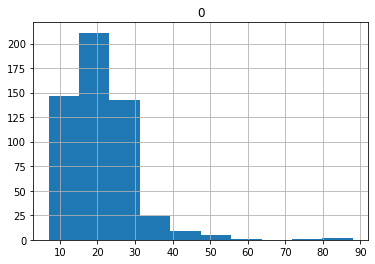

In [24]:
pd.DataFrame(pep_len['ACP']).hist()

### AMP dataset peptide length histogram
- Most of length were enriched under 30 AA residues

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

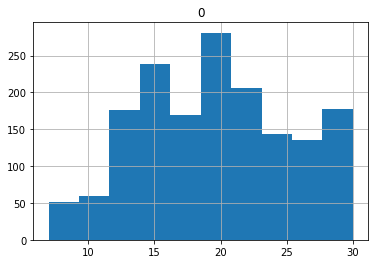

In [25]:
pd.DataFrame(pep_len['AMP']).hist()

### Peptide length cutoff as 30

## Dataset loading

In [32]:
sequences = dict()
pep_len = dict()
seq_len = dict()
for tgt, path in file_path.items():
    sequences[tgt] = list()
    pep_len[tgt] = list()
    for seq in SeqIO.parse(path,'fasta'):
        if 'x' not in str(seq.seq) and 'X' not in str(seq.seq) and len(seq.seq)<=30:
            sequences[tgt].append(seq) ### SeqRecord append (SeqRecord from Bio)
            pep_len[tgt].append(len(str(seq.seq))) ### Append each peptide sequence length 
        _len = len(sequences[tgt])
        seq_len[tgt] = _len
    print(f'{tgt} Sequence length: {_len}')

AMP Sequence length: 1636
ACP Sequence length: 496
AMP_noR Sequence length: 1314
ACP_noR Sequence length: 182
Negative Sequence length: 288675


In [33]:
seq_len

{'AMP': 1636, 'ACP': 496, 'AMP_noR': 1314, 'ACP_noR': 182, 'Negative': 288675}

### Train test dataset split

In [28]:
def nFoldSplit(dat, n_fold):
    data=copy.deepcopy(dat)

    random.shuffle(data)

    nFoldData = list()
    i=0
    while True:
        try:
            temp = data.pop()
            if i//n_fold==0:
                nFoldData.append([temp])
            else:
                idx = i%n_fold
                nFoldData[idx]+=[temp]
            i+=1
        except IndexError:
            break
    return nFoldData

In [29]:
def negative_sampling(neg_data, length):
    random.shuffle(neg_data)
    sampled_data = copy.deepcopy(neg_data[:length])
    neg_data = neg_data[length:]
    return sampled_data, neg_data

In [46]:
a+b

[1, 1, 1, 2, 2]

In [48]:
tr_seqs = dict()
tr_neg_seqs = dict()
test_seqs = dict()
test_neg_seqs = dict()


test_ratio = 0.3
for tgt in ['AMP','ACP']:
    seq_len = len(sequences[tgt])
    test_len = 163 if tgt=='ACP' else 491
    random.shuffle(sequences[f'{tgt}_noR'])
    test_seqs[tgt] = sequences[f'{tgt}_noR'][:test_len]
    test_neg_seqs[tgt], sequences['Negative'] = negative_sampling(sequences['Negative'], test_len)
    _trSeqsTemp = sequences[f'{tgt}_noR'][test_len:]+sequences[tgt]
    random.shuffle(_trSeqsTemp)
    tr_seqs[tgt] = nFoldSplit(_trSeqsTemp,n_fold = 5)
    neg_temp, sequences['Negative'] = negative_sampling(sequences['Negative'],len(_trSeqsTemp))
    tr_neg_seqs[tgt] = nFoldSplit(neg_temp, n_fold=5)
    

tot_data = list()
for tgt in ['AMP','ACP']:
    for fold, fold_data in enumerate(tr_seqs[tgt]):
        for seq in fold_data:
            tot_data.append([seq.id, str(seq.seq), 'train', fold, tgt, 1]) ## ID, Sequence, train, n_fold, target, Positive:1

    for fold, fold_data in enumerate(tr_neg_seqs[tgt]):
        for seq in fold_data:
            tot_data.append([seq.id, str(seq.seq), 'train', fold, tgt, 0]) ## ID, Sequence, train, n_fold, target, Negative:0
        
    for seq in test_seqs[tgt]:
        tot_data.append([seq.id, str(seq.seq), 'test', -1, tgt, 1]) ## ID, Sequence, train, n_fold, target, Negative:0

    for seq in test_neg_seqs[tgt]:
        tot_data.append([seq.id, str(seq.seq), 'test', -1, tgt, 0]) ## ID, Sequence, train, n_fold, target, Negative:0
        

    

In [51]:
pd.DataFrame(tot_data, columns=['ID', 'Sequence', 'Train/test', 'Num Fold', 'Target', 'Pos/Neg']).to_csv('./train_dataset/amp_acp_dataset.csv', index=None)

In [49]:
temp = pd.DataFrame(tot_data, columns=['ID', 'Sequence', 'Train/test', 'Num Fold', 'Target', 'Pos/Neg'])

In [50]:
#Final Dataset info
temp.groupby(['Train/test', 'Target', 'Pos/Neg']).size()

Train/test  Target  Pos/Neg
test        ACP     0           163
                    1           163
            AMP     0           491
                    1           491
train       ACP     0           379
                    1           379
            AMP     0          1145
                    1          1145
dtype: int64

### Load saved dataset

In [52]:
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [53]:
df = pd.read_csv('./train_dataset/amp_acp_dataset.csv')

In [54]:
df_AMP_Train_Positive = df[(df.Target=='AMP') & (df['Train/test']=='train') & (df['Pos/Neg']==1)]
df_ACP_Train_Positive = df[(df.Target=='ACP') & (df['Train/test']=='train') & (df['Pos/Neg']==1)]
df_AMP_Test_Positive = df[(df.Target=='AMP') & (df['Train/test']=='test') & (df['Pos/Neg']==1)]
df_ACP_Test_Positive = df[(df.Target=='ACP') & (df['Train/test']=='test') & (df['Pos/Neg']==1)]

In [55]:

def saveFasta(df, fName,prefix):
    seqs = list()
    for l in df.values:
        seqs.append(SeqRecord(Seq(str(l[1])),id = f'{prefix}_{l[0]}'))
    SeqIO.write(seqs, fName, 'fasta')

In [56]:
saveFasta(df_AMP_Train_Positive, 'AMP_Train.fasta','AMP')
saveFasta(df_ACP_Train_Positive, 'ACP_Train.fasta','ACP')
saveFasta(df_AMP_Test_Positive, 'AMP_Test.fasta','AMP')
saveFasta(df_ACP_Test_Positive, 'ACP_Test.fasta','ACP')